torch geometric 설치 (미설치 되어 있을 시)

In [1]:
import torch 

try:
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version.
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric

c:\Users\chang\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch 
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
from torch_geometric.datasets import WebKB

### 0. 데이터확인

In [4]:
# 임시저장이 아니라, 영구저장

# 경로지정
data_dir = "./data/texas/"

# 경로 생성
os.makedirs(data_dir, exist_ok=True)

# 데이터 로드
graph_dataset = WebKB(root=data_dir, name='texas')

In [5]:
# 그래프 속성 확인
print(f"전체 그래프 수 : {len(graph_dataset)}")
for idx,graph in enumerate(graph_dataset):
    print(f"====== {idx}번째 그래프의 특징은 다음과 같습니다. ======")
    print("그래프 KEY :",graph.keys)
    print("노드 수 :",graph.num_nodes) 
    print("엣지 수 :",graph.num_edges) 
    print("노드 특징 행렬 :",graph.num_node_features) 
    print("고립 노드 유무 :",graph.has_isolated_nodes())
    print("셀프 루프 유무 :",graph.has_self_loops()) 
    print("그래프 방향성 여부 :",graph.is_directed())
    print("학습되는 노드 수 :", graph.train_mask.sum())
    print("검증되는 노드 수 :", graph.val_mask.sum())
    print("테스트되는 노드 수 :", graph.test_mask.sum())
print(f"레이블 클래스 수 : {graph_dataset.num_classes}")

전체 그래프 수 : 1
====== 0번째 그래프의 특징은 다음과 같습니다. ======
그래프 KEY : ['val_mask', 'train_mask', 'y', 'x', 'test_mask', 'edge_index']
노드 수 : 183
엣지 수 : 325
노드 특징 행렬 : 1703
고립 노드 유무 : False
셀프 루프 유무 : True
그래프 방향성 여부 : True
학습되는 노드 수 : tensor(870)
검증되는 노드 수 : tensor(590)
테스트되는 노드 수 : tensor(370)
레이블 클래스 수 : 5


In [6]:
# Train/Valid/Test MASK가 Axis=1 이 10인 이유는 split 기준에따라, 10가지 case로 분리할 수 있음을 의미
print(graph)
graph.train_mask = graph.train_mask[:,0]
graph.val_mask = graph.val_mask[:,0]
graph.test_mask = graph.test_mask[:,0]
print(graph)

Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])
Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])


Text(0, 0.5, 'Numbers of Class')

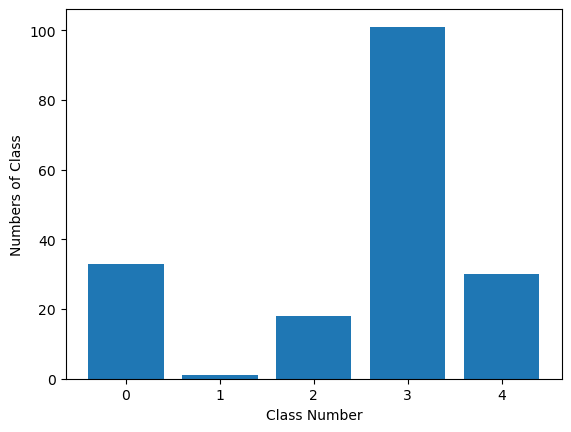

In [7]:
label_dict = dict(Counter(graph.y.numpy()))
label_dict = sorted(label_dict.items())
label = [i[0] for i in label_dict]
cnt = [i[1] for i in label_dict]
plt.bar(label,cnt)
plt.xlabel("Class Number")
plt.ylabel("Numbers of Class")

### 1. 플로팅

In [8]:
import networkx as nx
from torch_geometric.utils import to_networkx

In [9]:
import random

def make_color():
    '''RGB --> 16진수 얻어내는 함수'''
    r,g,b = random.randint(0,255),random.randint(0,255),random.randint(0,255)
    return rgb_to_hex(r,g,b)
    

def rgb_to_hex(r, g, b):
    '''RGB --> 16진수 변환'''
    r, g, b = int(r), int(g), int(b)
    return '#' + hex(r)[2:].zfill(2) + hex(g)[2:].zfill(2) + hex(b)[2:].zfill(2)

In [10]:
# torch_geometric.data.Data 인스턴스 --> networkx.Graph 로 변환
G = to_networkx(graph, to_undirected=False)

# 레이아웃 지정 (이쁘게 그리기 위함) - seed를 고정함으로써 그래프 배치 모양을 고정시킬 수 있음.
pos = nx.spring_layout(G, seed = 42)

# 레이블 클래스 정보 생성
label_dict = {
    0: "student",
    1: "project",
    2: "course",
    3: "staff",
    4: "faculty"}
    
label_lst = list(label_dict.values())

# 노드 정보 집계
# node_lst = [[]]*len(label_dict) # --> 이렇게 사용하면, 삽입되는 값이 모든리스트에 들어가진다..음..
node_lst = []
for _ in range(len(label_dict)):
    node_lst.append([])
for node_number, class_number in enumerate(graph.y):
    node_lst[class_number].append(node_number) # 노드번호 기입

# 색깔 정보 생성
color_lst = []
for _ in range(len(label_dict)):
    color_lst.extend([make_color()])

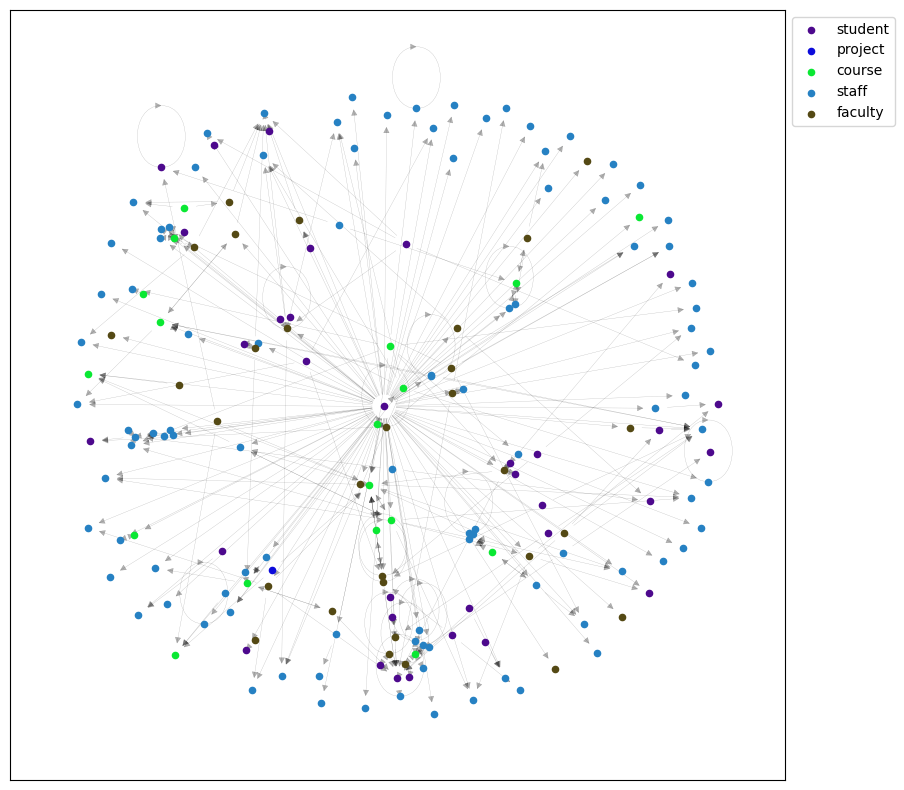

In [11]:
plt.figure(figsize = (10, 10))

for idx, node in enumerate(node_lst):
    
    # 클래스별로 노드 그림 (클래스 5개 이므로, 5번 실행됨)
    nx.draw_networkx_nodes(G, pos, 
                           nodelist=node, 
                           node_size=20, 
                           node_color=color_lst[idx], 
                           label=label_lst[idx])

# 엣지 그림
nx.draw_networkx_edges(G, pos, width = 0.2, alpha = 0.3)

# 범례 표시
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

### 2. 모델 구성

In [13]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [14]:
class GCN(torch.nn.Module):
    def __init__(self,dataset):
        super(GCN,self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16,dataset.num_classes)
    
    def forward(self,data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x,edge_index) # 입력이두개네..?
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x,edge_index) # 입력이두개네..?
        return F.log_softmax(x,dim=1)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(graph_dataset).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [16]:
print(model)

GCN(
  (conv1): GCNConv(1703, 16)
  (conv2): GCNConv(16, 5)
)


### 3. 학습

In [17]:
def compute_correct(pred_y, y):
    return (pred_y == y).sum()

In [19]:
graph = graph.to(device)
train_idx = graph.train_mask
test_idx = graph.test_mask
losses = []
accs = []

model.train()
for epoch in range(200):
    
    optimizer.zero_grad() 
    out = model(graph) # out : (2708,7)
    
    # 손실, 정확도 구함
    loss = F.nll_loss(out[train_idx], graph.y[train_idx])
    correct = compute_correct(out.argmax(dim=1)[train_idx],graph.y[train_idx]) # 2708 = 2708,2708
    acc = int(correct)/int(train_idx.sum())

    # 리스트에 담음
    losses.append(loss.item())
    accs.append(acc)

    # 역전파 및 최적화
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch : {epoch+1} / Loss : {np.round(loss.item(),5)} / Acc : {acc:.4f}")

Epoch : 10 / Loss : 0.88963 / Acc : 0.6667
Epoch : 20 / Loss : 0.70791 / Acc : 0.7816
Epoch : 30 / Loss : 0.5966 / Acc : 0.7471
Epoch : 40 / Loss : 0.46172 / Acc : 0.7931
Epoch : 50 / Loss : 0.44149 / Acc : 0.8276
Epoch : 60 / Loss : 0.51887 / Acc : 0.8161
Epoch : 70 / Loss : 0.38501 / Acc : 0.8736
Epoch : 80 / Loss : 0.43456 / Acc : 0.8161
Epoch : 90 / Loss : 0.42366 / Acc : 0.8506
Epoch : 100 / Loss : 0.40465 / Acc : 0.8621
Epoch : 110 / Loss : 0.43052 / Acc : 0.8046
Epoch : 120 / Loss : 0.36701 / Acc : 0.8506
Epoch : 130 / Loss : 0.32317 / Acc : 0.8621
Epoch : 140 / Loss : 0.34947 / Acc : 0.8391
Epoch : 150 / Loss : 0.32103 / Acc : 0.8276
Epoch : 160 / Loss : 0.29768 / Acc : 0.8851
Epoch : 170 / Loss : 0.24767 / Acc : 0.9310
Epoch : 180 / Loss : 0.39157 / Acc : 0.8621
Epoch : 190 / Loss : 0.32094 / Acc : 0.8506
Epoch : 200 / Loss : 0.25431 / Acc : 0.9195


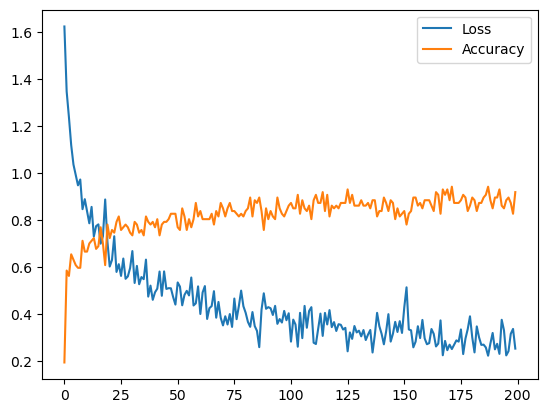

In [20]:
plt.plot(losses)
plt.plot(accs)
plt.legend(['Loss', 'Accuracy'])
plt.show()

### 4. 테스트

In [21]:
model.eval()
pred = model(graph).argmax(dim=1)
correct = compute_correct(pred[test_idx],graph.y[test_idx])
acc = int(correct) / int(test_idx.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.3784
